# Support vectore machines

We will be learning how to use **SVMs** in this notebook. SVMs are very powerful, and until not too long ago were considered state-of-the-art, but recently they have been relegated by neural networks and **deep learning**.

As our data set, we use a bank marketing data, which has demographic and activity data about bank customers, as well as information about previous attempts to contact them for a marketing campain. The target `y` is binary and indicates whether the client signed up for a term deposit or not.

You can read more about the data [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

In [1]:
import pandas as pd

bank = pd.read_csv("data/bank-full.csv", sep = ";")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Let's look at the scatter plot of the numeric columns in the data.

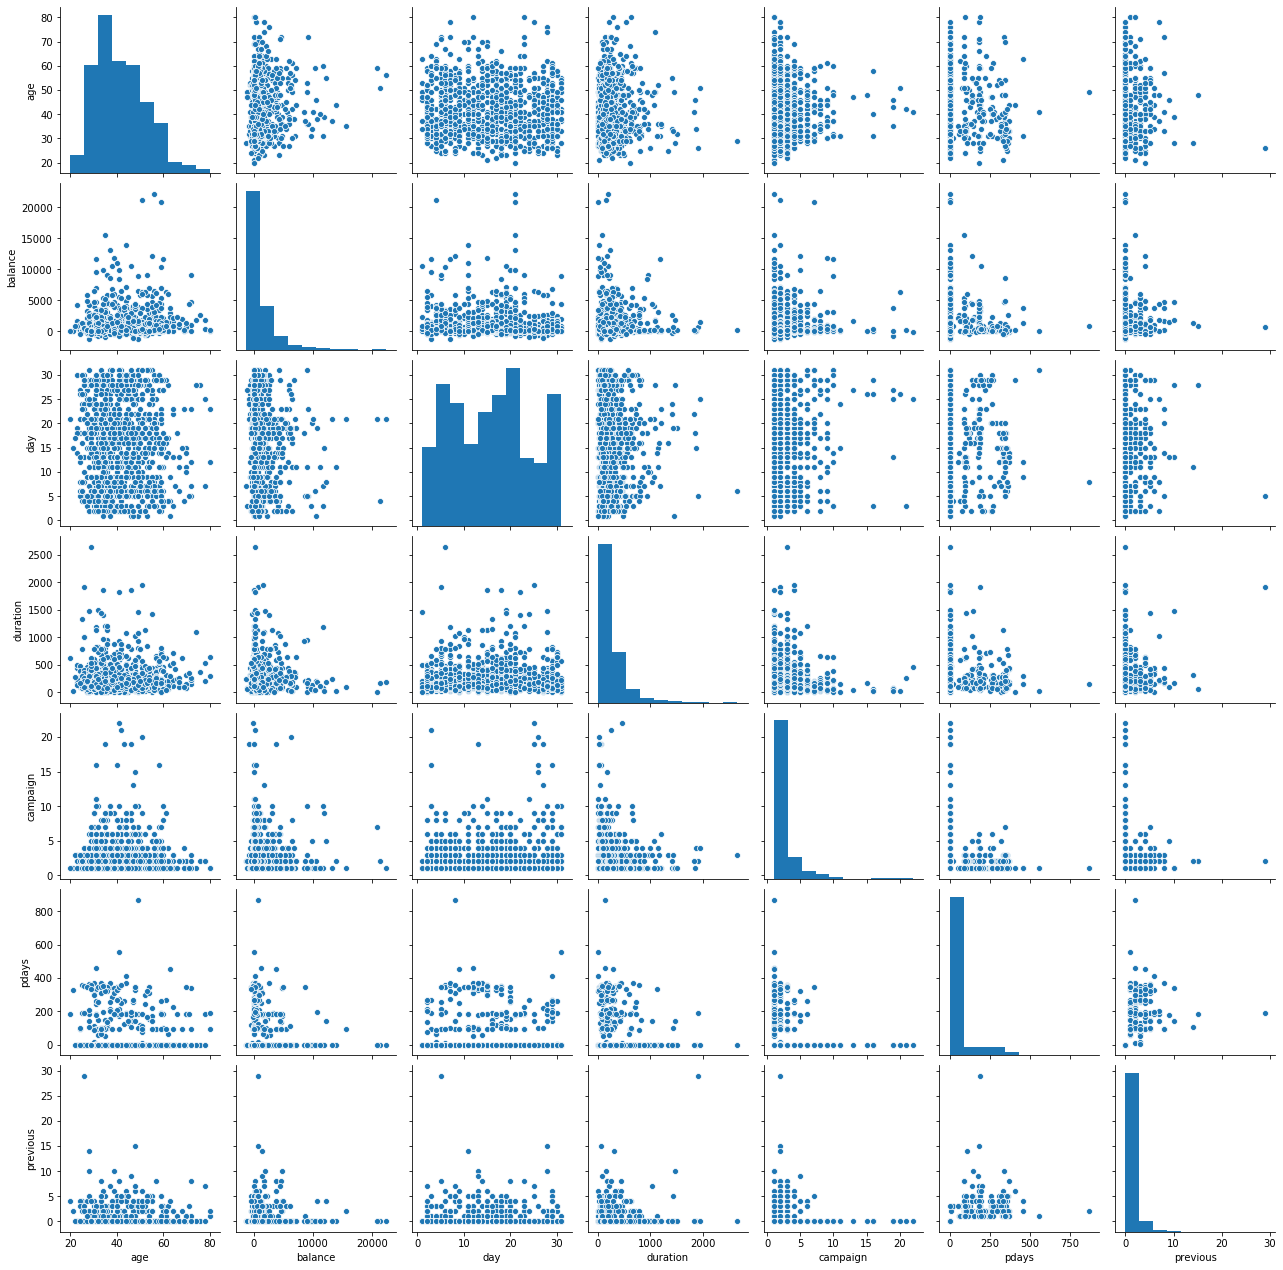

In [2]:
import seaborn as sns
sns.pairplot(bank.sample(1000));

Since numeric and categorical features are often pre-processed differently, we will create variables that store the names of each to make it easier to refer to them later.

In [3]:
num_cols = bank.select_dtypes(['integer', 'float']).columns
cat_cols = bank.select_dtypes(['object']).drop(columns = "y").columns

print("Numeric columns are {}.".format(", ".join(num_cols)))
print("Categorical columns are {}.".format(", ".join(cat_cols)))

Numeric columns are age, balance, day, duration, campaign, pdays, previous.
Categorical columns are job, marital, education, default, housing, loan, contact, month, poutcome.


We now need to split the data. SVMs can need a lot of tuning, so let's talk about splitting strategies. If we wanted to do our hyper-parameter tuning manually, then we would do a three-way split:

- the **training data** is used to train the model
- the **validation data** is used for **model selection**, i.e. to evaluate each model as we try different hyper-parameter combinations and select the best model, which we call the **final model**
- the **test data** is used to evaluate the final model so we have an unbiased estimate of its performance

To perform the three-way split, we first split the data into training and test data, and then further split the training data into training and validation.

However, using `sklearn` there's another way that we can tune our hyper-parameters using only a two-way split and **cross-validation** (we explain this later in the notebook):

- the **training data** is used to **both** to train many models and select the best, i.e. the training data is both the training data and the validation data
- the **test data** is used to evaluate the final model so we have an unbiased estimate of its performance

As we will see later, `sklearn` will handle a lot of the complexity for us, so we don't have to write our own code to do the model training and selection. So let's split the data into training and test data:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bank.drop(columns = "y"), bank["y"], 
                                                    test_size = 0.10, random_state = 42)

X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

print("Training data has {} rows.".format(X_train.shape[0]))
print("Test data has {} rows.".format(X_test.shape[0]))

Training data has 40689 rows.
Test data has 4522 rows.


Now we can start pre-processing the data. We begin by one-hot-encoding our categorical features.

In [5]:
from sklearn.preprocessing import OneHotEncoder

onehoter = OneHotEncoder(sparse = False)
onehoter.fit(X_train[cat_cols])
onehot_cols = onehoter.get_feature_names(cat_cols)
X_train_onehot = pd.DataFrame(onehoter.transform(X_train[cat_cols]), columns = onehot_cols)
X_test_onehot = pd.DataFrame(onehoter.transform(X_test[cat_cols]), columns = onehot_cols)

X_train_onehot.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Next we normalize our numeric features. It's important to normalize features when training an SVM algorithm.

In [6]:
from sklearn.preprocessing import StandardScaler

znormalizer = StandardScaler()
znormalizer.fit(X_train[num_cols])
X_train_norm = pd.DataFrame(znormalizer.transform(X_train[num_cols]), columns = num_cols)
X_test_norm = pd.DataFrame(znormalizer.transform(X_test[num_cols]), columns = num_cols)

X_train_norm.head()

,age,balance,day,duration,campaign,pdays,previous
0,-1.124112,-0.443322,-0.099012,0.231962,0.076064,-0.411045,-0.249556
1,1.510135,-0.314600,-0.459566,-0.581586,-0.244890,-0.411045,-0.249556
2,1.227894,-0.211233,-1.300857,-0.126155,-0.565844,-0.411045,-0.249556
3,1.039734,0.230193,-0.699935,-0.130048,-0.565844,-0.411045,-0.249556
4,-0.653711,0.134627,-1.421042,0.391557,-0.565844,1.216026,0.615550


In [7]:
X_train_featurized = X_train_onehot # add one-hot-encoded columns
X_test_featurized = X_test_onehot   # add one-hot-encoded columns
X_train_featurized[num_cols] = X_train_norm # add numeric columns
X_test_featurized[num_cols] = X_test_norm   # add numeric columns

del X_train_norm, X_test_norm, X_train_onehot, X_test_onehot

print("Featurized training data has {} rows and {} columns.".format(*X_train_featurized.shape))
print("Featurized test data has {} rows and {} columns.".format(*X_test_featurized.shape))

Featurized training data has 40689 rows and 51 columns.
Featurized test data has 4522 rows and 51 columns.


Before we begin traning with SVMs, recall that SVMs are very compute heavy and may require a lot of tuning. While we do all this in search of the best model, it's worthwhile having a **baseline** against which we can compare performance. So we first train a logistic regression model and evalutate it. We chose logistic regression because it is efficient and does a good job even without much tuning.

In [8]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter = 5000, solver = 'lbfgs')
logit.fit(X_train_featurized, y_train)

y_hat_train = logit.predict(X_train_featurized)
y_hat_test = logit.predict(X_test_featurized)

Because the problem is one of binary classification, we will evaluate each model by looking at **precision** and **recall**.

In [9]:
from sklearn.metrics import precision_score, recall_score
precision_train = precision_score(y_train, y_hat_train, pos_label = 'yes') * 100
precision_test = precision_score(y_test, y_hat_test, pos_label = 'yes') * 100

recall_train = recall_score(y_train, y_hat_train, pos_label = 'yes') * 100
recall_test = recall_score(y_test, y_hat_test, pos_label = 'yes') * 100

print("Precision = {:.0f}% and recall = {:.0f}% on the training data.".format(precision_train, recall_train))
print("Precision = {:.0f}% and recall = {:.0f}% on the validation data.".format(precision_test, recall_test))

Precision = 65% and recall = 35% on the training data.
Precision = 63% and recall = 34% on the validation data.


We can see that as expected precision and recall are slightly worse on the validation data than the training data, but not by enough that we should be worried about overfitting. So no need to tune the logistic regression model. We will take it as-is and use its performance as the baseline performance.

## SVM classifier

Let's now train an SVM model. SVM stands for **support vector machines** and before neural networks and deep learning started making a comeback in the last few years, SVMs were considered state of the art. And just like neural networks, SVMs are also very compute-heavy.

Note that by default, SVMs are **hard classifiers**, but by specifying `probability = True` we can get it to return soft predictions. Unfortunately, this comes at an added computational cost. But we need the soft predictions for later so we can plot an ROC plot.

In [12]:
from sklearn.svm import SVC

svmc = SVC(gamma = 'scale', cache_size = 1024) # cache size can improve performance
svmc.fit(X_train_featurized, y_train)

y_hat_train = svmc.predict(X_train_featurized)
y_hat_test = svmc.predict(X_test_featurized)
print('Done')

Done


SVMs have two important **high-level hyper-parameters** and then some lower-level ones that depend on the high-level ones. The high-level hyper-parameters are `C`, `kernel`. Depending on the choice of `kernel`, we can also specify `degree` and `gamma`. You can read more about that [here](https://scikit-learn.org/stable/modules/svm.html#kernel-functions).

In addition to the hyper-parameters mentioned above, `SVC` also has some important arguments such as `max_iter` and `class_weight`, or `cache_size` which we should be aware of.

We already did some hyper-parameter tuning in previous lectures, but we were a little loose about how we did it: (1) we didn't use a validation data like we should have, and (2) we had to write a lot of custom-code to collected results. If we try a few different models we can get away with being a little sloppy, but now we're going to do things right. You should not be surprised to find out that hyper-parameter tuning being a common ML task, there's functionality in `sklearn` to help us with it. 

There are three main ways to search the **hyper-parameter space**:

- **Grid search:** tries every combination of hyper-parameters
- **Random search:** tries a random subset of all combinations of hyper-parameters
- **Bayesian optimization:** tries a subset of all combinations of hyper-parameters (like random search) but does so in a more intelligent way, based on trading off the need to **explore** (trying a part of the hyper-parameter space thus far unexplored) and the need to **exploit** (focusing on a part of the hyper-parameter space that thus far seems promising)

We will use a grid search algorithm here. As a bonus, the grid search algorithm uses cross-validation (CV) to evaluate the model. Cross-validation can slow down the process, but we can use a lower number of **folds** to speed it up.

In [ ]:
from sklearn.model_selection import GridSearchCV
    
hyper_parameter_space = {'kernel': ['poly', 'rbf'], 
                         'degree': [4, 5],
                         'C': [4, 5], 
                         'gamma': [8, 10]}

svc = SVC(gamma = "scale", probability = False, cache_size = 4096)
clf = GridSearchCV(svc, hyper_parameter_space, 
                   cv = 5, refit = True, 
                   return_train_score = True, n_jobs=-1, verbose=10)

clf.fit(X_train_featurized, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


All the results generated form the work done by the grid search is stored in the `cv_results_` attribute. For example, if we want to know the combination of hyper-parameters that was tried in the 9th iteration, we can run this:

In [ ]:
%store clf

In [ ]:
clf.cv_results_['params'][9]

And if we want to know the cross-validated evaluation score for that 9th itearation, we can run this:

In [ ]:
clf.cv_results_['mean_test_score'][9]

We need to be careful about terminology here. Unfortunately, the hyper-parameters are called `params` by `GridSearchCV`. But in ML **parameters** are the things that the algorithm learns from the data (such as the coefficients in the prediction equation), whereas **hyper-parameters** cannot be learned from the data, which is why we have to tune them by trying different combination. Also, the cross-validated score is called `mean_test_score` even though we are not using the test data to evaluate it. At least not during model selection. We will use the test data later to evaluate the final model.

There is one important note about the best estimator worth mentioning. Whether the data is broken up into either training and validation, or we use cross-validation, there is a common practice after model selection is over: we retrain the model using the whole training data. This is because the more training data we use the more accurate our model's parameters are. So once we hone in on the hyper-parameters for the final model, we can take this optional step in the hope of slightly increasing the model's performance. With `GridSearch` we are spared from having to take this step manually: instead we just use `refit = True` as we did above.

Time to pull the best model. We can explicitly call `clf.best_estimator_`. 

In [ ]:
clf.best_estimator_

Calling `clf.best_estimator_` explicitly is not necessary: by calling `clf` itself it is **implied** that we are calling the best estimator. One way we can check that is by comparing `clf.best_estimator_` with `clf.estimator`. These two estimators should be the same, confirming that the `estimator` method is set the `best_estimator_` once training is done.

In [ ]:
clf.estimator

This means that if we call `clf.predict`, we would be using the best estimator to get predictions.

In [ ]:
y_hat_train = clf.predict(X_train_featurized)
y_hat_test = clf.predict(X_test_featurized)

Let's now get the precision and recall of the best estimator to see how they compare to what we got from logistic regression.

In [ ]:
precision_train = precision_score(y_train, y_hat_train, pos_label = 'yes') * 100
precision_test = precision_score(y_test, y_hat_test, pos_label = 'yes') * 100

recall_train = recall_score(y_train, y_hat_train, pos_label = 'yes') * 100
recall_test = recall_score(y_test, y_hat_test, pos_label = 'yes') * 100

print("Precision = {:.0f}% and recall = {:.0f}% on the training data.".format(precision_train, recall_train))
print("Precision = {:.0f}% and recall = {:.0f}% on the validation data.".format(precision_test, recall_test))

For grid search we set `probability = True` so we can get ROC curve and compare the best model to logistic regression.

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(models, model_names):
    plt.figure(0, figsize = [8, 7]).clf()
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    for ii, model in enumerate(models):
        y_prob_test = model.predict_proba(X_test_featurized)[:, 1]
        fpr, tpr, threshold = roc_curve(y_test, y_prob_test, pos_label = "yes")
        roc_auc = auc(fpr, tpr)

        fpr, tpr, threshold = roc_curve(y_test, y_prob_test, pos_label = "yes")
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = "{} AUC = {:0.2f}".format(model_names[ii], roc_auc))

    plt.legend(loc = 'lower right');

An ROC curve for a single classifer is not very useful, but it's when we want to compare multiple classifiers that the ROC curve can save us a lot of time. Since creating an ROC curve can be tedious, the above cell has a function that does the hard work. When we call the function, all we need to do is give it the models we trained, in a list, and corresponding labels for each. In addition to plotting the ROC curve, the plot will also show the AUC (area under the ROC curve). The closer the AUC is to 1, the better the model.

In [ ]:
plot_roc([clf, logit], ['svm (tuned)', 'logit (baseline)'])